Original dataset shape: (11686, 32)
Dataset after removing rows with missing key variables: (8944, 32)

Dataset after all cleaning steps: (8944, 38)
Classification threshold (median QG): 5.180
Class distribution:
QG_cat
Low     4490
High    4454
Name: count, dtype: int64

Checking for remaining missing values:
Regression dataset missing values: 0
Classification dataset missing values: 0

Final dataset sizes:
Regression: (8944, 28)
Classification: (8944, 28)

Train-test split:
  Regression - Train: 6260, Test: 2684
  Classification - Train: 6260, Test: 2684

PART 1: REGRESSION MODELS (Predicting Continuous QG_log)

--- Feature Selection using Lasso ---
Number of features selected by Lasso: 26
Selected features: ['X28fecal_log', 'ecoli_log', 'totalc_log', 'Fever', 'Chills', 'Eyedisc', 'Earache', 'Skinrash', 'Infectn', 'Nausea']...

--- Model 1: Multiple Linear Regression ---
Linear Regression R²: 0.526
Linear Regression RMSE: 0.073
Linear Regression MAE: 0.057

--- Model 2: Random Forest

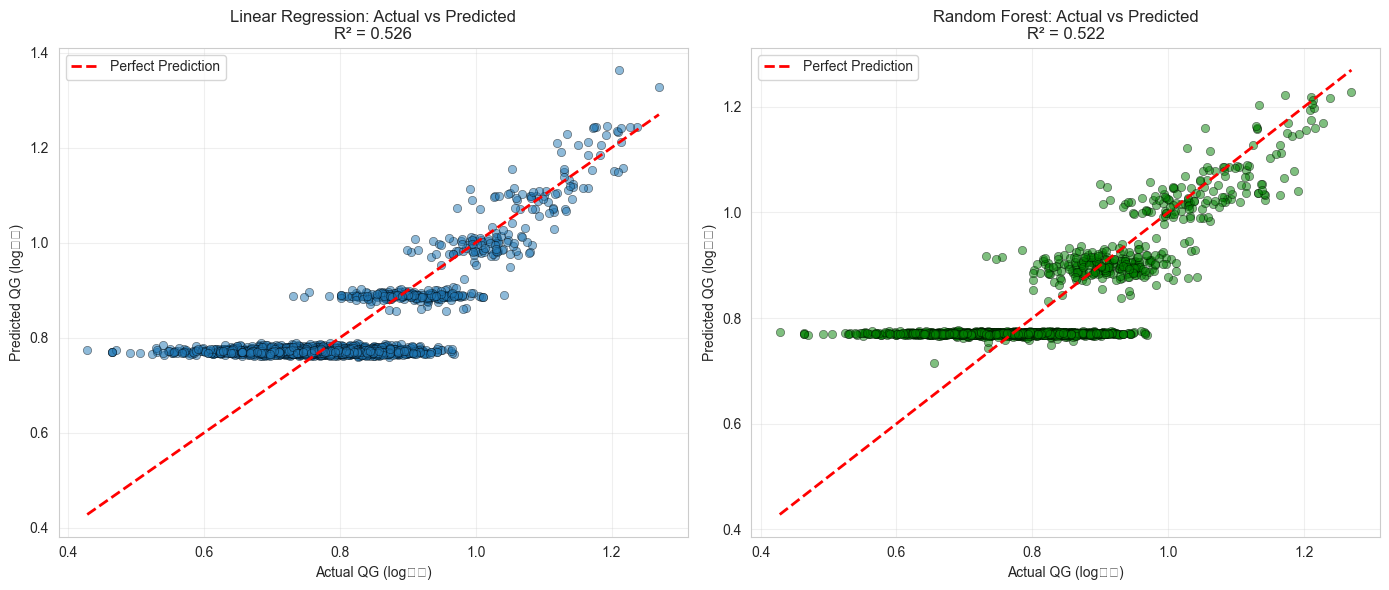

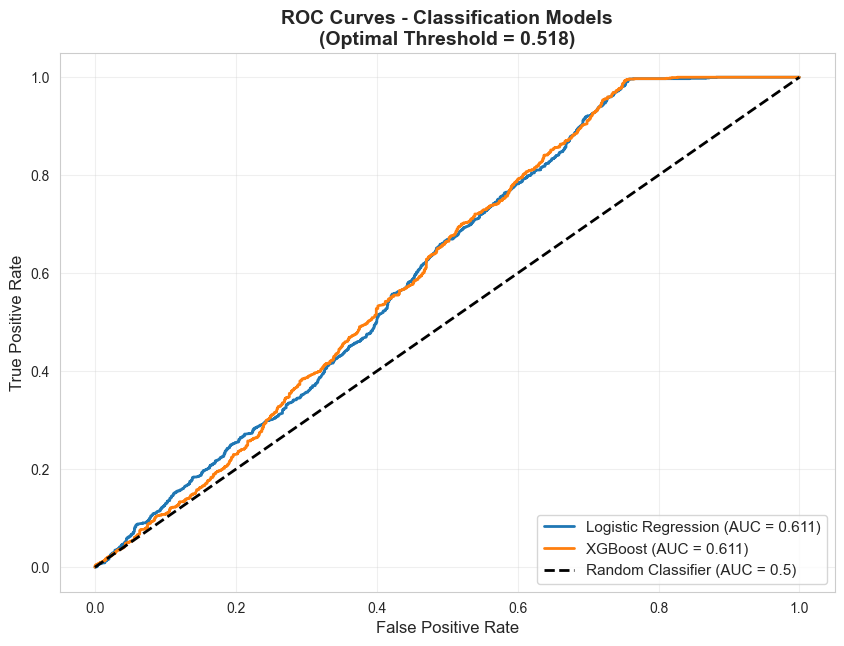

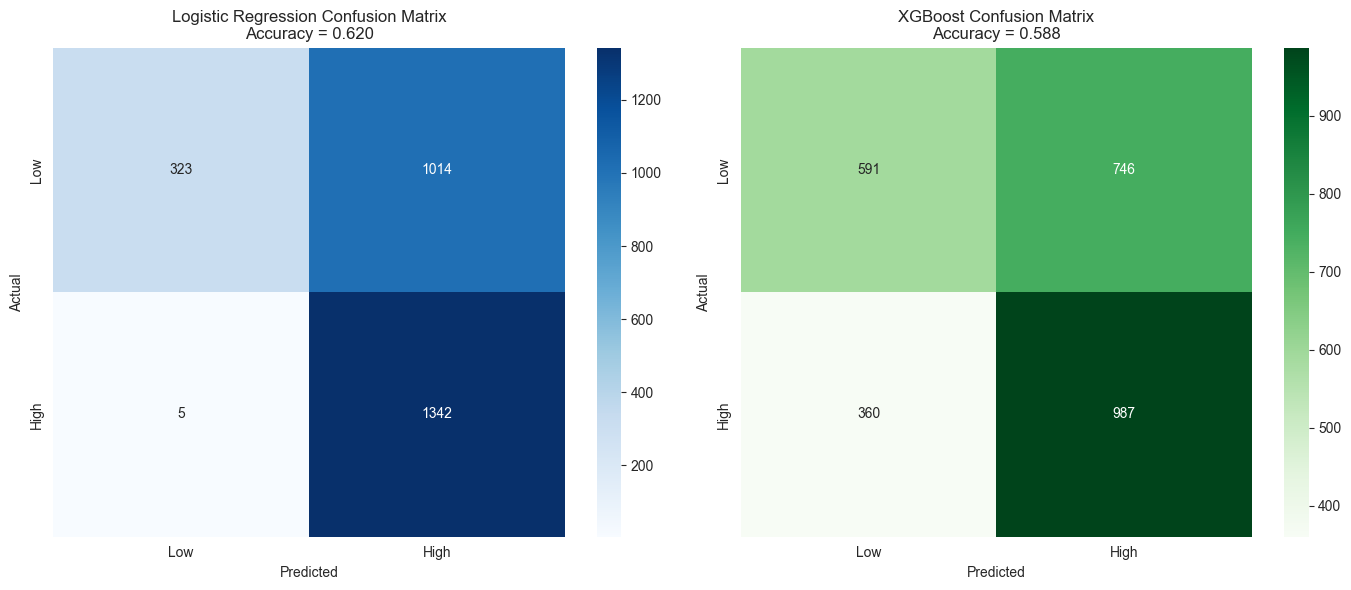

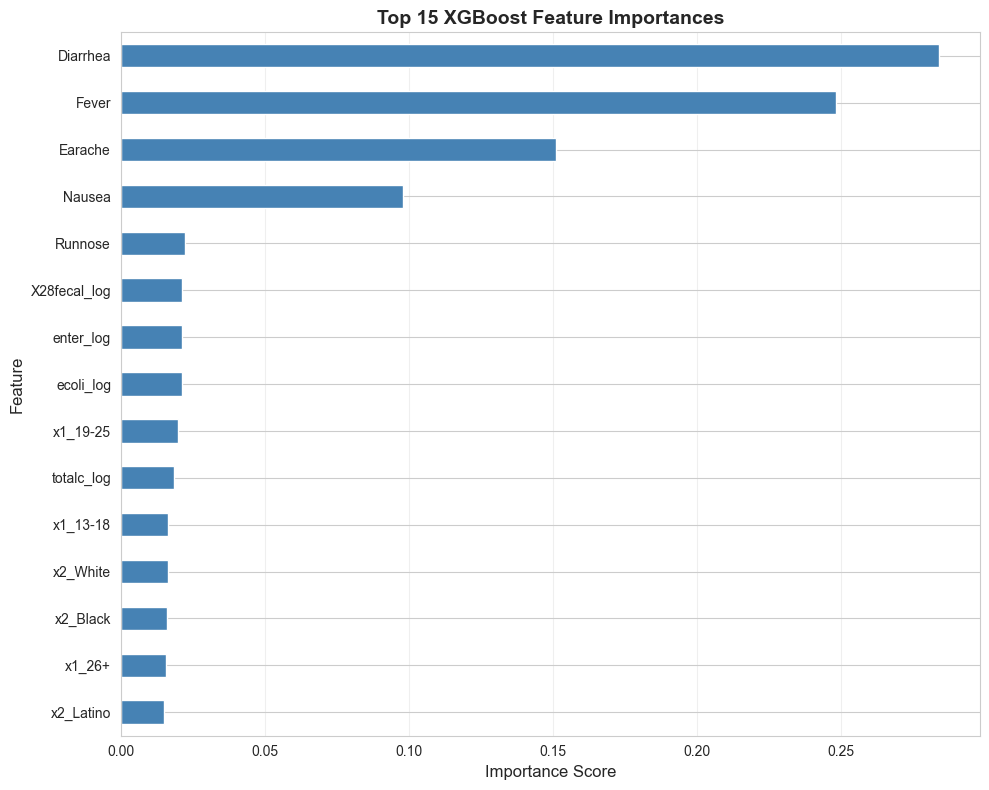

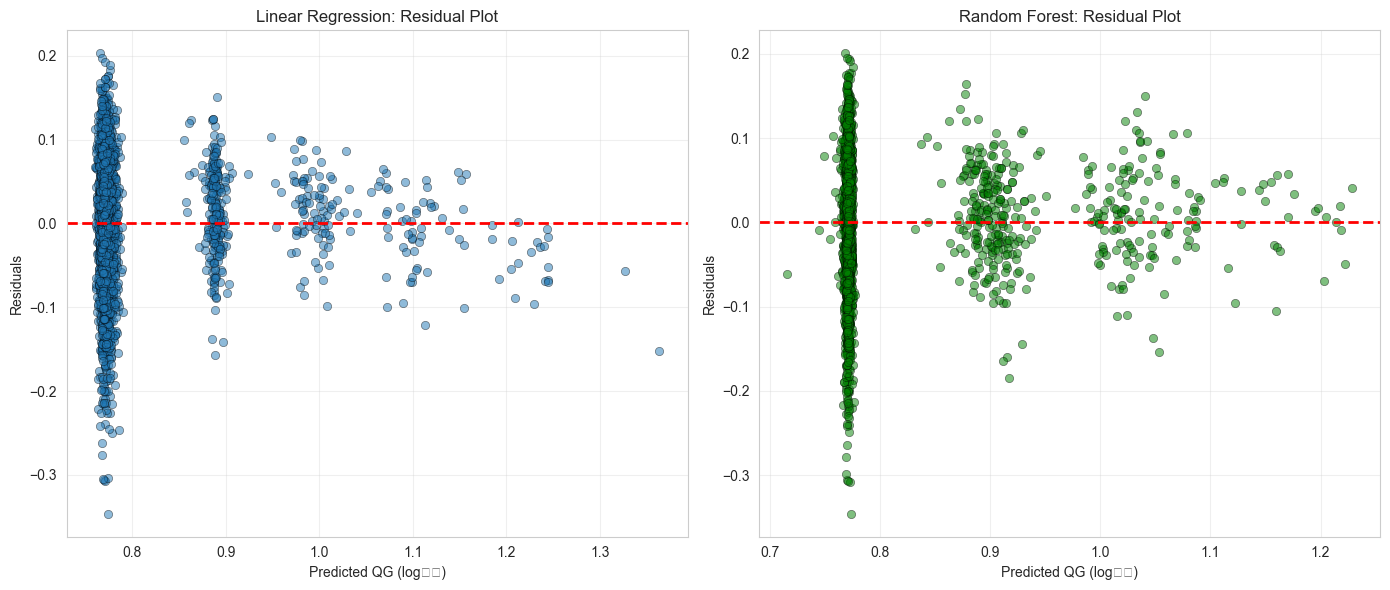


ANALYSIS COMPLETE!
All visualizations saved as PNG files.


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc, roc_auc_score,
                             classification_report)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
df = pd.read_csv('santa.csv')
print(f"Original dataset shape: {df.shape}")

# Replace missing values (99999.99 coded as missing)
df = df.replace(99999.99, np.nan)

# Drop rows with missing microbial indicators and SES (as you did in your EDA)
df = df.dropna(subset=['ses', 'X28fecal', 'ecoli', 'enter', 'totalc'])
print(f"Dataset after removing rows with missing key variables: {df.shape}")

# Create log-transformed microbial variables
df['X28fecal_log'] = np.log10(df['X28fecal'] + 1)
df['ecoli_log'] = np.log10(df['ecoli'] + 1)
df['enter_log'] = np.log10(df['enter'] + 1)
df['totalc_log'] = np.log10(df['totalc'] + 1)

# Create log-transformed target for regression
df['QG_log'] = np.log10(df['QG'] + 1)

# ====== Proper Mapping of Numeric Categories to String Labels ======
race_map = {0: 'White', 1: 'Black', 2: 'Latino', 3: 'Asian', 4: 'Multiethnic/Other'}
age_map = {8: '0-12', 7: '13-18', 6: '19-25', 5: '26+'}
areacat_map = {0: '400_yds', 1: '50_100_yds', 2: '1_50_yds', 3: '0_yds'}
sex_map = {0: 'Female', 1: 'Male'}

def safe_map_and_fill(series, mapping):
    s = series.map(mapping).astype('category')
    if 'Unknown' not in s.cat.categories:
        s = s.cat.add_categories('Unknown')
    return s.fillna('Unknown')

df['X6race'] = safe_map_and_fill(df['X6race'], race_map)
df['Agenew'] = safe_map_and_fill(df['Agenew'], age_map)
df['areacat'] = safe_map_and_fill(df['areacat'], areacat_map)
df['sex'] = safe_map_and_fill(df['sex'], sex_map)

# Define variables
target_regress = 'QG_log'
target_class = 'QG_cat'
microbial_vars = ['X28fecal_log', 'ecoli_log', 'enter_log', 'totalc_log']
distance_var = ['areacat']
covariates = [
    'sex', 'Agenew', 'X6race',
    'Fever', 'Chills', 'Eyedisc', 'Earache', 'Eardisc', 'Skinrash',
    'Infectn', 'Nausea', 'Vomiting', 'Diarrhea', 'Diwbld', 'Stompain',
    'Cough', 'Cghphlm', 'Runnose', 'Sorethrt', 'HCGI1', 'HCGI2', 'SigResD'
]
predictors = microbial_vars + distance_var + covariates

# ====== Prepare binary classification target based on median QG ======
# Note: QG should have no missing values after the initial cleaning
threshold = df['QG'].median()
df[target_class] = np.where(df['QG'] <= threshold, 'Low', 'High')
df[target_class] = df[target_class].astype('category')

print(f"\nDataset after all cleaning steps: {df.shape}")
print(f"Classification threshold (median QG): {threshold:.3f}")
print(f"Class distribution:\n{df[target_class].value_counts()}")

# Prepare regression and classification datasets
# Use .copy() to avoid modifying the original and only drop if truly necessary
df_reg = df[predictors + [target_regress]].copy()
df_clf = df[predictors + [target_class]].copy()

print(f"\nChecking for remaining missing values:")
print(f"Regression dataset missing values: {df_reg.isnull().sum().sum()}")
print(f"Classification dataset missing values: {df_clf.isnull().sum().sum()}")

# Only drop NaN if there are actually missing values remaining
if df_reg.isnull().sum().sum() > 0:
    print(f"Dropping {df_reg.isnull().any(axis=1).sum()} rows with missing values in regression dataset")
    df_reg = df_reg.dropna()
    
if df_clf.isnull().sum().sum() > 0:
    print(f"Dropping {df_clf.isnull().any(axis=1).sum()} rows with missing values in classification dataset")
    df_clf = df_clf.dropna()

print(f"\nFinal dataset sizes:")
print(f"Regression: {df_reg.shape}")
print(f"Classification: {df_clf.shape}")

X_reg = df_reg[predictors]
y_reg = df_reg[target_regress]

X_clf = df_clf[predictors]
y_clf = df_clf[target_class]

# Train-test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42)

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.3, stratify=y_clf, random_state=42)

print(f"\nTrain-test split:")
print(f"  Regression - Train: {X_reg_train.shape[0]}, Test: {X_reg_test.shape[0]}")
print(f"  Classification - Train: {X_clf_train.shape[0]}, Test: {X_clf_test.shape[0]}")

# Define numeric and categorical features
numeric_features = microbial_vars + [
    'Fever', 'Chills', 'Eyedisc', 'Earache', 'Eardisc', 'Skinrash',
    'Infectn', 'Nausea', 'Vomiting', 'Diarrhea', 'Diwbld', 'Stompain',
    'Cough', 'Cghphlm', 'Runnose', 'Sorethrt', 'HCGI1', 'HCGI2', 'SigResD'
]
categorical_features = ['sex', 'Agenew', 'X6race', 'areacat']

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\n" + "="*80)
print("PART 1: REGRESSION MODELS (Predicting Continuous QG_log)")
print("="*80)

# ====== LASSO FEATURE SELECTION FOR REGRESSION ======
print("\n--- Feature Selection using Lasso ---")
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(cv=5, random_state=42))
])
lasso_pipeline.fit(X_reg_train, y_reg_train)

all_feature_names = numeric_features + list(
    lasso_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)
lasso_coefs = lasso_pipeline.named_steps['lasso'].coef_
selected_features_reg = [feat for coef, feat in zip(lasso_coefs, all_feature_names) if np.abs(coef) > 1e-5]

print(f"Number of features selected by Lasso: {len(selected_features_reg)}")
print(f"Selected features: {selected_features_reg[:10]}...")  # Show first 10

def build_reduced_preprocessor(selected_features):
    num_feats = [f for f in selected_features if f in numeric_features]
    cat_feats = [f for f in selected_features if f not in numeric_features]
    mapped_cat_feats = list({feat.split('_')[0] for feat in cat_feats})

    return ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_feats if num_feats else numeric_features[:1]),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), mapped_cat_feats if mapped_cat_feats else categorical_features[:1])
    ])

reduced_preprocessor_reg = build_reduced_preprocessor(selected_features_reg)

X_reg_train_red = reduced_preprocessor_reg.fit_transform(X_reg_train)
X_reg_test_red = reduced_preprocessor_reg.transform(X_reg_test)

# ====== MODEL 1: LINEAR REGRESSION ======
print("\n--- Model 1: Multiple Linear Regression ---")
linreg = LinearRegression()
linreg.fit(X_reg_train_red, y_reg_train)
y_pred_linreg = linreg.predict(X_reg_test_red)

r2_linreg = r2_score(y_reg_test, y_pred_linreg)
rmse_linreg = np.sqrt(mean_squared_error(y_reg_test, y_pred_linreg))
mae_linreg = mean_absolute_error(y_reg_test, y_pred_linreg)

print(f"Linear Regression R²: {r2_linreg:.3f}")
print(f"Linear Regression RMSE: {rmse_linreg:.3f}")
print(f"Linear Regression MAE: {mae_linreg:.3f}")

# ====== MODEL 2: RANDOM FOREST REGRESSOR ======
print("\n--- Model 2: Random Forest Regressor ---")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_reg = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf_reg, rf_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_rf.fit(X_reg_train_red, y_reg_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_reg_test_red)

r2_rf = r2_score(y_reg_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_reg_test, y_pred_rf))
mae_rf = mean_absolute_error(y_reg_test, y_pred_rf)

print(f"Random Forest best params: {grid_rf.best_params_}")
print(f"Random Forest R²: {r2_rf:.3f}")
print(f"Random Forest RMSE: {rmse_rf:.3f}")
print(f"Random Forest MAE: {mae_rf:.3f}")

print("\n" + "="*80)
print("PART 2: CLASSIFICATION MODELS (Predicting High vs Low QG)")
print("="*80)

# ====== FEATURE SELECTION FOR CLASSIFICATION ======
print("\n--- Feature Selection using Random Forest Importance ---")
X_clf_train_full = preprocessor.fit_transform(X_clf_train)
rf_clf_fs = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_fs.fit(X_clf_train_full, y_clf_train)

feature_names = numeric_features + list(
    preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
)
importances_clf = pd.Series(rf_clf_fs.feature_importances_, index=feature_names).sort_values(ascending=False)
top_n_clf = 15
top_features_clf = importances_clf.head(top_n_clf).index.tolist()

print(f"Top {top_n_clf} selected features for classification:")
print(top_features_clf)

reduced_preprocessor_clf = build_reduced_preprocessor(top_features_clf)

X_clf_train_red = reduced_preprocessor_clf.fit_transform(X_clf_train)
X_clf_test_red = reduced_preprocessor_clf.transform(X_clf_test)

# Apply SMOTE for class imbalance
sm = SMOTE(random_state=42)
X_clf_train_res, y_clf_train_res = sm.fit_resample(X_clf_train_red, y_clf_train)

print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_clf_train_res).value_counts())

# Encode labels
le = LabelEncoder()
y_clf_train_enc = le.fit_transform(y_clf_train_res)
y_clf_test_enc = le.transform(y_clf_test)

# ====== MODEL 1: LOGISTIC REGRESSION WITH STRATIFIED K-FOLD CV ======
print("\n--- Model 1: Logistic Regression (L1 penalty) ---")

# Use Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_logreg = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1'],
    'solver': ['liblinear'],
    'max_iter': [1000],
}

logreg = LogisticRegression()
grid_logreg = GridSearchCV(logreg, param_logreg, scoring='f1_macro', cv=skf, n_jobs=-1, verbose=1)
grid_logreg.fit(X_clf_train_res, y_clf_train_enc)

best_logreg = grid_logreg.best_estimator_
print(f"Logistic Regression best params: {grid_logreg.best_params_}")
print(f"Best CV F1 score: {grid_logreg.best_score_:.3f}")

# Get probability predictions
y_pred_proba_lr = best_logreg.predict_proba(X_clf_test_red)[:, 1]

# Find optimal threshold using F1 score
from sklearn.metrics import precision_recall_curve

print("\n--- Finding Optimal Threshold for Logistic Regression ---")
precision, recall, thresholds = precision_recall_curve(y_clf_test_enc, y_pred_proba_lr)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
optimal_idx = np.argmax(f1_scores)
OPTIMAL_THRESHOLD_LR = thresholds[optimal_idx]

print(f"Optimal threshold found: {OPTIMAL_THRESHOLD_LR:.3f}")
print(f"Expected F1 score at optimal threshold: {f1_scores[optimal_idx]:.3f}")

# Apply optimal threshold for Logistic Regression
y_pred_logreg_enc_adjusted = (y_pred_proba_lr >= OPTIMAL_THRESHOLD_LR).astype(int)
y_pred_logreg_adjusted = le.inverse_transform(y_pred_logreg_enc_adjusted)

print(f"\nUsing optimal threshold for Logistic Regression: {OPTIMAL_THRESHOLD_LR:.3f}")

# ====== MODEL 2: XGBOOST WITH STRATIFIED K-FOLD CV ======
print("\n--- Model 2: XGBoost Classifier ---")

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
param_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 0.8]
}

grid_xgb = GridSearchCV(xgb_clf, param_xgb, scoring='f1_macro', cv=skf, n_jobs=-1, verbose=1)
grid_xgb.fit(X_clf_train_res, y_clf_train_enc)

best_xgb = grid_xgb.best_estimator_
print(f"XGBoost best params: {grid_xgb.best_params_}")
print(f"Best CV F1 score: {grid_xgb.best_score_:.3f}")

# Get probability predictions for XGBoost
y_pred_proba_xgb = best_xgb.predict_proba(X_clf_test_red)[:, 1]

# Use same optimal threshold for fair comparison
y_pred_xgb_enc_adjusted = (y_pred_proba_xgb >= OPTIMAL_THRESHOLD_LR).astype(int)
y_pred_xgb_adjusted = le.inverse_transform(y_pred_xgb_enc_adjusted)

print(f"\nUsing same threshold for XGBoost: {OPTIMAL_THRESHOLD_LR:.3f}")

# ====== EVALUATION FUNCTION ======
def evaluate_cls(name, y_true, y_pred, y_pred_proba=None):
    print(f"\n{name} Classification Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.3f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.3f}")
    print(f"F1 (macro): {f1_score(y_true, y_pred, average='macro'):.3f}")
    if y_pred_proba is not None:
        y_true_enc = le.transform(y_true)
        print(f"ROC-AUC: {roc_auc_score(y_true_enc, y_pred_proba):.3f}")
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return cm

print("\n" + "="*80)
print(f"CLASSIFICATION RESULTS WITH OPTIMAL THRESHOLD ({OPTIMAL_THRESHOLD_LR:.3f})")
print("="*80)

cm_lr = evaluate_cls('Logistic Regression', y_clf_test, y_pred_logreg_adjusted, y_pred_proba_lr)
cm_xgb = evaluate_cls('XGBoost', y_clf_test, y_pred_xgb_adjusted, y_pred_proba_xgb)

# ====== VISUALIZATIONS ======
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# 1. Model Performance Comparison Table
print("\n--- Model Performance Summary ---")
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Logistic Regression', 'XGBoost'],
    'Type': ['Regression', 'Regression', 'Classification', 'Classification'],
    'Primary Metric': [f'R²: {r2_linreg:.3f}', f'R²: {r2_rf:.3f}', 
                       f'Accuracy: {accuracy_score(y_clf_test, y_pred_logreg_adjusted):.3f}',
                       f'Accuracy: {accuracy_score(y_clf_test, y_pred_xgb_adjusted):.3f}'],
    'Secondary Metric': [f'RMSE: {rmse_linreg:.3f}', f'RMSE: {rmse_rf:.3f}',
                        f'F1: {f1_score(y_clf_test, y_pred_logreg_adjusted, average="macro"):.3f}',
                        f'F1: {f1_score(y_clf_test, y_pred_xgb_adjusted, average="macro"):.3f}']
})
print(results_df.to_string(index=False))

# 2. Regression: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_reg_test, y_pred_linreg, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].plot([y_reg_test.min(), y_reg_test.max()], 
             [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual QG (log₁₀)')
axes[0].set_ylabel('Predicted QG (log₁₀)')
axes[0].set_title(f'Linear Regression: Actual vs Predicted\nR² = {r2_linreg:.3f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_reg_test, y_pred_rf, alpha=0.5, edgecolors='k', linewidth=0.5, color='green')
axes[1].plot([y_reg_test.min(), y_reg_test.max()], 
             [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual QG (log₁₀)')
axes[1].set_ylabel('Predicted QG (log₁₀)')
axes[1].set_title(f'Random Forest: Actual vs Predicted\nR² = {r2_rf:.3f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. ROC Curves for Classification Models
fpr_lr, tpr_lr, _ = roc_curve(y_clf_test_enc, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_xgb, tpr_xgb, _ = roc_curve(y_clf_test_enc, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curves - Classification Models\n(Optimal Threshold = {OPTIMAL_THRESHOLD_LR:.3f})', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# 4. Confusion Matrices Side by Side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
axes[0].set_title(f'Logistic Regression Confusion Matrix\nAccuracy = {accuracy_score(y_clf_test, y_pred_logreg_adjusted):.3f}')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
axes[1].set_title(f'XGBoost Confusion Matrix\nAccuracy = {accuracy_score(y_clf_test, y_pred_xgb_adjusted):.3f}')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# 5. Feature Importance for XGBoost
# Get the actual categorical features used in reduced_preprocessor_clf
def get_actual_cat_features(top_features_list, all_cat_features):
    """Extract which categorical features are actually used based on one-hot encoded names"""
    used_cats = set()
    for feat in top_features_list:
        for cat in all_cat_features:
            if feat.startswith(cat + '_'):
                used_cats.add(cat)
    return list(used_cats)

actual_cat_features = get_actual_cat_features(top_features_clf, categorical_features)

def get_feature_names_fixed(preproc):
    """Get feature names from the fitted preprocessor"""
    # Get numeric features
    num_feats = [t[2] for t in preproc.transformers_ if t[0] == 'num'][0]
    
    # Get categorical feature names from the fitted encoder
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out()
    
    return list(num_feats) + list(cat_names)

xgb_feature_names = get_feature_names_fixed(reduced_preprocessor_clf)

# Verify dimensions match
if len(xgb_feature_names) != len(best_xgb.feature_importances_):
    print(f"Warning: Feature name count ({len(xgb_feature_names)}) doesn't match importance count ({len(best_xgb.feature_importances_)})")
    # Fallback to generic names
    xgb_feature_names = [f"Feature_{i}" for i in range(len(best_xgb.feature_importances_))]

importances = pd.Series(best_xgb.feature_importances_, index=xgb_feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importances.tail(15).plot(kind='barh', color='steelblue')
plt.title('Top 15 XGBoost Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 6. Residuals Plot for Regression
residuals_lr = y_reg_test - y_pred_linreg
residuals_rf = y_reg_test - y_pred_rf

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_pred_linreg, residuals_lr, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted QG (log₁₀)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Linear Regression: Residual Plot')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_pred_rf, residuals_rf, alpha=0.5, edgecolors='k', linewidth=0.5, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted QG (log₁₀)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Random Forest: Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

